In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import time
import csv
import os

## Funzione per trasformare i dati in CSV
Lo script prende in input un file .txt con il parametro 'rb' quindi in lettura in formato bytecode che vuol dire che dovrà essere decodificato.
Per prima cosa si scorre fino alla riga che inizia con 'NR' perché i dati iniziano da li, quando la trovo imposto flag_data a 1 che serve a dirmi che da li in poi dovrò salvare le righe.
Cerco la prima riga che inizia con '0' e la salto settando firsr_row a 1.
Quando sia data_flag che first_row sono a 1 allora inizio a salvare le righe.

Per salvare le righe:
* prima le decodifico con .decode()
* poi le divido con .split() che se usato senza parametri splitta la stringa in base agli spazi
* unisco i valori delle ultime due colonne perché fanno entrambi riferimento alla data
* elimino l'ultima riga perché l'ho unita alla penultima
* faccio un append della riga


In [13]:
def txt_to_csv(filename, filedest):
    
    
    if os.path.isfile(filedest + '.csv'):
        os.remove(filedest + '.csv')
        
    file1 = open(filename + '.txt', "rb")
    file_csv = open(filedest + '.csv', 'w+', newline ='')

    count = 0
    flag_data = 0

    with file_csv:
        for line in file1:

            if b'\xb0C' in line:     # se trovo il carattere °C lo ignoro
                pass
            else:
                line = line.decode() # altrimenti decodifico la riga

                # cerco la riga con i nomi della tabella
                if line.startswith('NR'):
                    flag_data = 1                  # quando trovo i nomi delle colonne imposto flag_data = 1
                    table_names = line.split()     # divido i nomi delle colonne      
                    table_names.remove('LastLine') # elimino 'LastLine' che fa riferimento ad un singolo dato duplicato
                    #for item in table_names: print(item)
                    write = csv.writer(file_csv)  
                    write.writerow(table_names)
                    #print(table_names)

                # Se sono arrivato alla tabella ma la riga inizia con 0 la salto
                elif flag_data == 1 and line.startswith('0'):
                    pass

                # Se sono arrivato alla tabella (flag_data == 1) e non sono alla prima riga
                # inizio a salvare i dati
                elif flag_data == 1:
                    row = line.split()

                    if not line.startswith('[END]') and len(row) == len(table_names)+1: # le righe con meno di 25 elementi hanno dati mancanti
                        row[-2] = str(row[-2]) + ' ' + str(row[-1]) # unisco l'ora col giorno
                        del row[-1] # elimino la colonna con i giorni
                        write = csv.writer(file_csv)
                        write.writerow(row)
                        count = count+1      # aggiorno il contatore delle righe

    #print(str(count) + ' righe salvate.')

#txt_to_csv(filename = 'table/DiagnosisTabl',
#           filedest = 'table/csv/DiagnosisTabl')

FileNotFoundError: [Errno 2] No such file or directory: 'table/DiagnosisTabl.txt'

Per convertire tutti i file da txt a csv mi basta iterare all'interno della cartella e passare ogni file alla funzione txt_to_csv che prende in input il nome del file da convertire e il percorso di destinazione del file.

In [16]:
import os

for filename in os.listdir('table/'):
    if filename.endswith(".txt"): 
        print(filename[:-4])
        txt_to_csv(filename = 'table/' + filename[:-4],
                   filedest = 'table/csv/' + filename[:-4])

TabLogPostTHS3
TabLogPostTHS4
DiagnosisTabl2
TabLogFMS2_SX
TabLogFMS3_SX
TabLogAntTHS4
DiagnTableBasaments4
DiagnosisTabl3
DiagnosisTable
TabLogFMS3_DX
DiagnosisTable4
TabLogPostTHS
TabLogFMS2_DX
DiagnosisTabl4
DiagnTableBasaments
TabLogFMS4_SX
TabLogAntTHS
TabLogAntTHS2
DiagnosisTable3
DiagnTableBasaments3
TabLogPostTHS2
TabLogFMS_DX
TabLogFMS4_DX
LONG_TERM_TEMP
TabLogFMS_SX
DiagnTableBasaments2
DiagnosisTable2
TabLogAntTHS3


## Funzione per caricare il CSV in un DataFrame
La funzione prende in input il nome del file .csv da caricare, converte la colonna DataTime in datetime e la imposta come indice del dataframe. Controlla se il dataframe è ordinato e se non lo è lo riordina. Elimina la colonna NR. Restituisce il dataframe.

In [7]:
def load_data(file):
    #column_subset = ['t_Mach',   't_HydrTa', 't_TTlubr', 't_TT_ab1', 
                     #'t_TT_ab2', 't_HdStUp', 't_HdStLw', 't_Sfrnt1', 
                     #'t_Sfrnt2', 't_Srear',  't_Smotor', 'DataTime']

    df = pd.read_csv (file,
                      #usecols=column_subset,
                      index_col=False)

    df['DataTime'] = pd.to_datetime(df['DataTime'], format='%H:%M:%S %d.%m.%Y')
    
    df.set_index('DataTime', drop = True, inplace=True)
    
    if not df.index.is_monotonic:
        df.sort_index(inplace = True)
    
    df.drop('NR', axis=1, inplace=True)
    
    return df

## Processo per caricare tutti i file dello stesso tipo e salvarli come unico csv

In [10]:
def create_single_csv(path_folder, tab_name):
    data_list=[]

    for filename in os.listdir(path_folder):
        if tab_name in filename: 
            data = load_data(path_folder + 'csv/' + filename[:-4] + '.csv')
            data_list.append(data)

    data_all = pd.concat(data_list)
    data_all.sort_index(inplace = True)
    data_all.to_csv(path_folder + '/csv/' + tab_name + '_all.csv')


create_single_csv('table/', 'DX')

 * Faccio una lista con tutti i nomi dei file ma senza il numero progressivo alla fine
 * Per ogni nome in lista cerco le tabelle con quel nome e le riunisco creando un unico file csv

In [14]:
import os
from tqdm import tqdm
import shutil

# controllo se la cartella 'csv' è presente. Se c'è la elimino e la ricreo, se non c'è la creo.
if os.path.isdir('table/csv'):
    shutil.rmtree('table/csv')
    os.mkdir('table/csv')
else:
    os.mkdir('table/csv')

#per ogni file .txt creo il corrispettivo in .csv nella cartella table/csv
table_list = []
pbar = tqdm(os.listdir('table/'), desc='converto .txt in .csv\t')
for filename in pbar:
    if filename.endswith(".txt"):
        #t.set_description("Bar desc (file %i)" % i)
        print(filename[:-4])
        txt_to_csv(filename = 'table/' + filename[:-4],
                   filedest = 'table/csv/' + filename[:-4])
        
        # creo una lista con i nomi delle tabelle da unire
        if not filename[-5:-4].isdigit():
            table_list.append(filename[:-4])

# unisco i csv
pbar = tqdm(table_list, desc='unisco le tabelle\t')
for table in pbar:
    create_single_csv('table/', table)

# elimino i file originali e tengo solo i .csv uniti
pbar = tqdm(os.listdir('table/csv'), desc='elimino tab divise\t')
for filename in pbar:
    if not filename.endswith('_all.csv'):
        os.remove('table/csv/'+filename)
        
print(table_list)

converto .txt in .csv	:   2%|▎         | 1/40 [00:00<00:07,  5.30it/s]

TabLogPostTHS3
TabLogPostTHS4


converto .txt in .csv	:  12%|█▎        | 5/40 [00:00<00:03, 10.41it/s]

DiagnosisTabl2
TabLogFMS2_SX


converto .txt in .csv	:  18%|█▊        | 7/40 [00:00<00:04,  7.67it/s]

TabLogFMS3_SX
TabLogAntTHS4


converto .txt in .csv	:  22%|██▎       | 9/40 [00:01<00:04,  6.68it/s]

DiagnTableBasaments4
DiagnosisTabl3


converto .txt in .csv	:  25%|██▌       | 10/40 [00:01<00:05,  5.19it/s]

DiagnosisTable


converto .txt in .csv	:  35%|███▌      | 14/40 [00:02<00:03,  7.11it/s]

TabLogFMS3_DX
DiagnosisTable4


converto .txt in .csv	:  40%|████      | 16/40 [00:02<00:03,  6.24it/s]

TabLogPostTHS
TabLogFMS2_DX


converto .txt in .csv	:  45%|████▌     | 18/40 [00:02<00:02,  7.70it/s]

DiagnosisTabl4


converto .txt in .csv	:  50%|█████     | 20/40 [00:03<00:03,  6.17it/s]

DiagnTableBasaments
TabLogFMS4_SX


converto .txt in .csv	:  60%|██████    | 24/40 [00:03<00:01,  9.05it/s]

TabLogAntTHS
TabLogAntTHS2


converto .txt in .csv	:  65%|██████▌   | 26/40 [00:03<00:01,  7.39it/s]

DiagnosisTable3
DiagnTableBasaments3


converto .txt in .csv	:  70%|███████   | 28/40 [00:04<00:01,  6.33it/s]

TabLogPostTHS2
TabLogFMS_DX


converto .txt in .csv	:  72%|███████▎  | 29/40 [00:04<00:01,  5.86it/s]

TabLogFMS4_DX


converto .txt in .csv	:  75%|███████▌  | 30/40 [00:04<00:01,  5.03it/s]

LONG_TERM_TEMP
TabLogFMS_SX


converto .txt in .csv	:  88%|████████▊ | 35/40 [00:05<00:00,  8.01it/s]

DiagnTableBasaments2
DiagnosisTable2


converto .txt in .csv	:  90%|█████████ | 36/40 [00:05<00:00,  6.77it/s]

TabLogAntTHS3


elimino tab divise	: 100%|██████████| 41/41 [00:00<00:00, 2947.26it/s]

['TabLogFMS2_SX', 'TabLogFMS3_SX', 'DiagnosisTable', 'TabLogFMS3_DX', 'TabLogPostTHS', 'TabLogFMS2_DX', 'DiagnTableBasaments', 'TabLogFMS4_SX', 'TabLogAntTHS', 'TabLogFMS_DX', 'TabLogFMS4_DX', 'LONG_TERM_TEMP', 'TabLogFMS_SX']


In [74]:
create_single_csv('table/', 'TabLogFMS_DX')
df = pd.read_csv ('table/csv/TabLogFMS_DX_all.csv', index_col='DataTime')
df.index = pd.to_datetime(df.index)
df.plot()

FileNotFoundError: [Errno 2] No such file or directory: 'table/csv/TabLogFMS_DX_all.csv'

DiagnosisTabl3
DiagnosisTabl2
DiagnosisTable3
DiagnosisTable
DiagnosisTable4
DiagnosisTabl4
DiagnosisTable2
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209658 entries, 2019-06-15 19:25:00 to 2021-06-12 18:50:00
Freq: 5T
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t_Mach    14449 non-null  float64
 1   t_HydrTa  14449 non-null  float64
 2   t_TTlubr  14449 non-null  float64
 3   t_TT_ab1  14449 non-null  float64
 4   t_TT_ab2  14449 non-null  float64
 5   t_HdStUp  14449 non-null  float64
 6   t_HdStLw  14449 non-null  float64
 7   t_Sfrnt1  14449 non-null  float64
 8   t_Sfrnt2  14449 non-null  float64
 9   t_Srear   14449 non-null  float64
 10  t_Smotor  14449 non-null  float64
 11  S_Load    14449 non-null  float64
 12  tCo_H_X1  14449 non-null  float64
 13  tCo_H_Y1  14449 non-null  float64
 14  tCo_H_Z1  14449 non-null  float64
 15  tCo_H_X2  14449 non-null  float64
 16  tCo_H_Y2  14449 non-null  float

<AxesSubplot:xlabel='DataTime'>

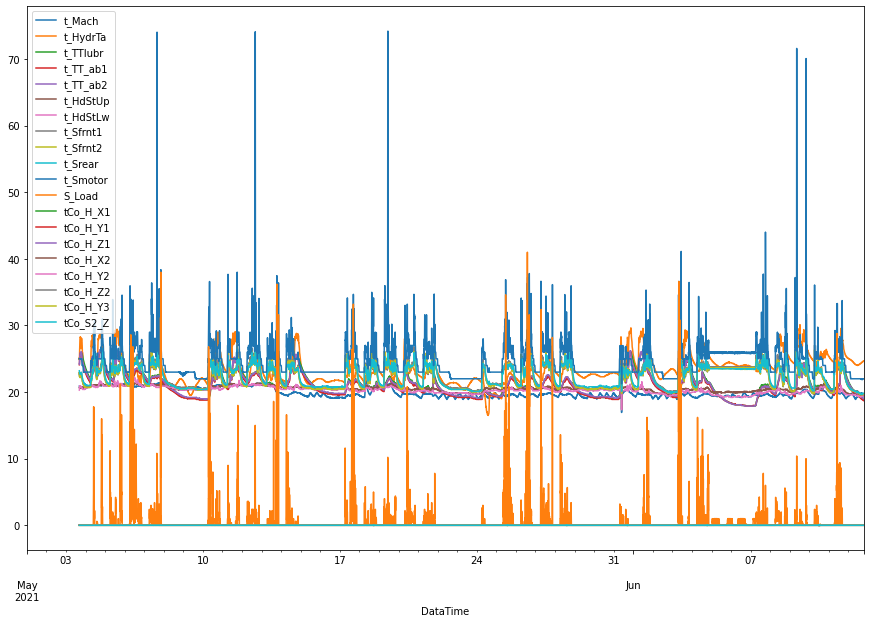

In [51]:
diagnosisTablList = []
for file in os.listdir('table/csv'):
    if file.endswith('SX.csv'):
        #print(file)
        pass
    if file.endswith('DX.csv'):
        #print(file)
        pass
    if 'DiagnosisTabl' in file:
        print(file[:-4])
        data = load_data('table/csv/'+file)
        diagnosisTablList.append(data)
        
data_all = pd.concat(diagnosisTablList)
data_all.sort_index(inplace = True)
data_all = data_all.resample('5T').mean()
del data_all['S_Speed']
data_all.info()
data_all['2021-05-01':].plot(figsize=(15,10))
#data_all.to_csv(path_folder + '/csv/' + tab_name + '_all.csv')

2021-05-13 17:38:01 982
2021-05-13 17:45:01 982
2021-05-14 06:48:01 1591
2021-05-14 06:49:01 1591
2021-05-14 06:50:01 1592
2021-05-14 06:51:01 1592
2021-05-14 06:52:01 1593
2021-05-14 06:53:01 1592
2021-05-14 06:54:01 1591
2021-05-14 06:55:01 1591
2021-05-14 06:56:01 1592
2021-05-14 06:57:01 1592
2021-05-14 06:58:01 1589
2021-05-14 06:59:01 1591
2021-05-14 07:00:01 1592
2021-05-14 07:01:01 1592
2021-05-14 07:02:01 1592
2021-05-14 07:03:01 1592
2021-05-14 07:04:01 1591
2021-05-14 07:05:01 1591
2021-05-14 07:06:01 1592
2021-05-14 07:07:01 1593
2021-05-14 07:08:01 1591
2021-05-14 07:09:01 1594
2021-05-14 07:10:01 1592
2021-05-14 07:11:01 1592
2021-05-14 07:12:01 1591
2021-05-14 07:14:01 1592
2021-05-14 07:15:01 1590
2021-05-14 07:16:01 1593
2021-05-14 07:17:01 1592
2021-05-14 07:18:01 1592
2021-05-14 07:19:01 1592
2021-05-14 07:20:01 1591
2021-05-14 07:21:01 1591
2021-05-14 07:22:01 1593
2021-05-14 07:23:01 1591
2021-05-14 07:24:01 1591
2021-05-14 07:25:01 1592
2021-05-14 07:26:01 1591
20

2021-05-17 17:41:01 999
2021-05-17 17:42:01 997
2021-05-17 17:45:01 994
2021-05-17 17:46:01 994
2021-05-17 17:48:01 994
2021-05-17 17:49:01 993
2021-05-17 17:50:01 994
2021-05-17 17:51:01 998
2021-05-17 17:52:01 995
2021-05-17 17:53:01 994
2021-05-17 17:54:01 995
2021-05-17 17:55:01 999
2021-05-17 17:56:01 994
2021-05-17 17:57:01 996
2021-05-17 17:58:01 995
2021-05-17 17:59:01 995
2021-05-17 18:00:01 994
2021-05-17 18:02:01 997
2021-05-17 18:05:01 995
2021-05-17 18:06:01 992
2021-05-17 18:07:01 995
2021-05-17 18:08:01 994
2021-05-17 18:09:01 987
2021-05-17 18:10:01 997
2021-05-17 18:11:01 994
2021-05-17 18:12:01 982
2021-05-17 18:13:01 990
2021-05-17 18:14:01 995
2021-05-17 18:15:01 994
2021-05-17 18:16:01 994
2021-05-17 18:17:01 996
2021-05-17 18:20:01 1591
2021-05-17 18:21:01 1592
2021-05-17 18:22:01 1592
2021-05-17 18:23:01 1592
2021-05-17 18:24:01 1592
2021-05-17 18:25:01 1591
2021-05-17 18:26:01 1591
2021-05-17 18:27:01 1592
2021-05-17 18:28:01 1591
2021-05-17 18:29:01 1592
2021-0

2021-05-19 17:53:01 1100
2021-05-19 17:54:01 1099
2021-05-19 17:55:01 1100
2021-05-19 17:57:01 1099
2021-05-19 17:58:01 1100
2021-05-19 17:59:01 1100
2021-05-19 18:00:01 1100
2021-05-19 18:01:01 1099
2021-05-19 18:02:01 1100
2021-05-19 18:03:01 1100
2021-05-19 18:04:01 1100
2021-05-19 18:05:01 1100
2021-05-19 18:06:01 1100
2021-05-19 18:09:01 4676
2021-05-19 18:10:01 4660
2021-05-19 19:39:01 1010
2021-05-19 19:40:01 1011
2021-05-19 19:42:01 1010
2021-05-19 19:43:01 1010
2021-05-19 19:46:01 3184
2021-05-19 19:47:01 3184
2021-05-19 19:48:01 3183
2021-05-19 19:49:01 3181
2021-05-19 19:50:01 3182
2021-05-19 19:51:01 3182
2021-05-19 19:52:01 3183
2021-05-19 19:53:01 3184
2021-05-19 19:54:01 3183
2021-05-19 19:55:01 3183
2021-05-19 19:56:01 3181
2021-05-19 19:57:01 3182
2021-05-19 19:59:01 1272
2021-05-19 20:00:01 1272
2021-05-19 20:01:01 1273
2021-05-19 20:02:01 1272
2021-05-19 20:03:01 1272
2021-05-20 07:48:01 3500
2021-05-20 07:49:01 3499
2021-05-20 07:50:01 3499
2021-05-20 07:51:01 3499


2021-05-21 06:25:01 1431
2021-05-21 06:26:01 1431
2021-05-21 06:29:01 1432
2021-05-21 06:30:01 1431
2021-05-21 06:59:01 1431
2021-05-21 07:01:01 1431
2021-05-21 07:03:01 1432
2021-05-21 07:08:01 1140
2021-05-21 07:11:01 4972
2021-05-21 07:28:01 2159
2021-05-21 07:34:01 2160
2021-05-21 07:35:01 2160
2021-05-21 07:36:01 2159
2021-05-21 07:39:01 2379
2021-05-21 07:40:01 2380
2021-05-21 07:41:01 2379
2021-05-21 07:43:01 2380
2021-05-21 07:44:01 2380
2021-05-21 07:45:01 2379
2021-05-21 07:46:01 2380
2021-05-21 07:47:01 2379
2021-05-21 07:48:01 2381
2021-05-21 07:52:01 2349
2021-05-21 07:54:01 2349
2021-05-21 07:55:01 2349
2021-05-21 07:56:01 2350
2021-05-21 07:58:01 2330
2021-05-21 07:59:01 2350
2021-05-21 08:01:01 4973
2021-05-21 08:02:01 4973
2021-05-21 08:03:01 4973
2021-05-21 08:04:01 4974
2021-05-21 08:05:01 4975
2021-05-21 08:06:01 4973
2021-05-21 08:07:01 4972
2021-05-21 08:08:01 4974
2021-05-21 08:09:01 4973
2021-05-21 08:10:01 4975
2021-05-21 08:11:01 4975
2021-05-21 08:12:01 4975


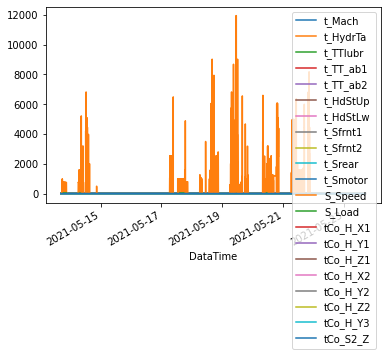

In [41]:
diagnosisTablList[0].plot()

for index, row in diagnosisTablList[0].iterrows():
    if row['S_Speed'] > 800:
        print(index, row['S_Speed'])

In [59]:
dataDict={}
for filename in os.listdir('table/csv'):
    print(filename)
    df = pd.read_csv ('table/csv/'+filename, index_col='DataTime')
    dataDict[filename[:-4]] = df


dataDict['TabLogAntTHS_all'].head()

TabLogAntTHS_all.csv
TabLogFMS2_DX_all.csv
DiagnTableBasaments_all.csv
TabLogFMS_SX_all.csv
DiagnosisTable_all.csv
TabLogFMS2_SX_all.csv
TabLogFMS4_SX_all.csv
LONG_TERM_TEMP_all.csv
TabLogFMS4_DX_all.csv
TabLogFMS3_SX_all.csv
TabLogPostTHS_all.csv
TabLogFMS3_DX_all.csv
TabLogFMS_DX_all.csv


,t_Mach,t_HydrTa,t_TTlubr,t_TT_ab1,t_TT_ab2,t_HdStUp,t_HdStLw,t_Sfrnt1,t_Sfrnt2,t_Srear,t_Smotor,t_ReqDom,t_ExtDom,t_ProDom,t_Envir
DataTime,,,,,,,,,,,,,,,
2021-04-29 08:23:01,19.4,21.6,19.2,19.2,19.3,20.7,20.4,23.0,23.3,23.6,25.6,20,20,20,21.4
2021-04-29 08:24:01,19.4,21.6,19.2,19.2,19.3,20.7,20.4,23.0,23.3,23.6,25.0,20,20,20,21.4
2021-04-29 08:25:01,19.4,21.6,19.2,19.2,19.3,20.7,20.4,22.9,23.2,23.6,25.6,20,20,20,21.4
2021-04-29 08:26:01,19.4,21.6,19.2,19.2,19.3,20.7,20.4,23.3,23.3,23.6,26.0,20,20,20,21.4
2021-04-29 08:27:01,19.4,21.6,19.2,19.2,19.3,20.7,20.4,23.6,23.5,23.6,26.0,20,20,20,21.4
